In [289]:
import pandas as pd

In [290]:
train = pd.read_csv('./ai-4-ba-ml-2024-yield-forecasting/train.csv')
test = pd.read_csv('./ai-4-ba-ml-2024-yield-forecasting/test.csv')

In [291]:
train.head()

,id,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,228.0,12.5,0.25,0.25,0.50,0.75,94.6,57.2,79.0,68.2,33.0,55.9,24.0,0.39,0.622623,0.513172,43.937002,8357.06722
1,1,693.0,25.0,0.50,0.38,0.38,0.75,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.391598,0.401275,30.546306,3937.91539
2,2,624.0,25.0,0.50,0.25,0.75,0.63,94.6,57.2,79.0,68.2,33.0,55.9,34.0,0.56,0.428322,0.412450,32.344457,4560.22361
3,3,639.0,25.0,0.50,0.38,0.38,0.75,69.7,42.1,58.2,50.2,24.3,41.2,34.0,0.56,0.504853,0.433081,35.517539,5597.02216
4,4,646.0,25.0,0.50,0.25,0.75,0.63,77.4,46.8,64.7,55.8,27.0,45.8,34.0,0.56,0.483873,0.445484,35.285926,5535.05665


In [292]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    15000 non-null  int64  
 1   Row#                  15000 non-null  float64
 2   clonesize             15000 non-null  float64
 3   honeybee              15000 non-null  float64
 4   bumbles               15000 non-null  float64
 5   andrena               15000 non-null  float64
 6   osmia                 15000 non-null  float64
 7   MaxOfUpperTRange      15000 non-null  float64
 8   MinOfUpperTRange      15000 non-null  float64
 9   AverageOfUpperTRange  15000 non-null  float64
 10  MaxOfLowerTRange      15000 non-null  float64
 11  MinOfLowerTRange      15000 non-null  float64
 12  AverageOfLowerTRange  15000 non-null  float64
 13  RainingDays           15000 non-null  float64
 14  AverageRainingDays    15000 non-null  float64
 15  fruitset           

In [293]:
train.isna().sum()

id                      0
Row#                    0
clonesize               0
honeybee                0
bumbles                 0
andrena                 0
osmia                   0
MaxOfUpperTRange        0
MinOfUpperTRange        0
AverageOfUpperTRange    0
MaxOfLowerTRange        0
MinOfLowerTRange        0
AverageOfLowerTRange    0
RainingDays             0
AverageRainingDays      0
fruitset                0
fruitmass               0
seeds                   0
yield                   0
dtype: int64

In [294]:
train.set_index('id', inplace=True)

In [295]:
index = len(train) - 100
tmp = train
train = tmp[:index]
val = tmp[index:]

In [296]:
len(train)

14900

In [297]:
len(val)

100

In [298]:
def remove_outlier(df, column):
    cal_Q1 = df[column].quantile(0.25)
    cal_Q3 = df[column].quantile(0.75)
    cal_IQR = cal_Q3 - cal_Q1

    lower_limit = cal_Q1 - 1.5 * cal_IQR
    upper_limit = cal_Q3 + 1.5 * cal_IQR

    df = df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]

    return df

In [299]:
cols = train.columns.to_list()
for col in cols:
    train = remove_outlier(train, col)

In [300]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

def plot_relationship():
    sns.set(style="whitegrid")

    features = train.columns.drop('yield')
    num_features = len(features)

    # Calculate grid size based on the number of features
    rows = math.ceil(num_features / 4)
    cols = min(num_features, 4)

    plt.figure(figsize=(15, rows * 3))  # Adjust height dynamically

    for i, feature in enumerate(features, 1):
        plt.subplot(rows, cols, i)
        sns.scatterplot(x=train[feature], y=train['yield'], alpha=0.7)
        plt.title(f'{feature} vs Yield')
        plt.tight_layout()

    plt.show()

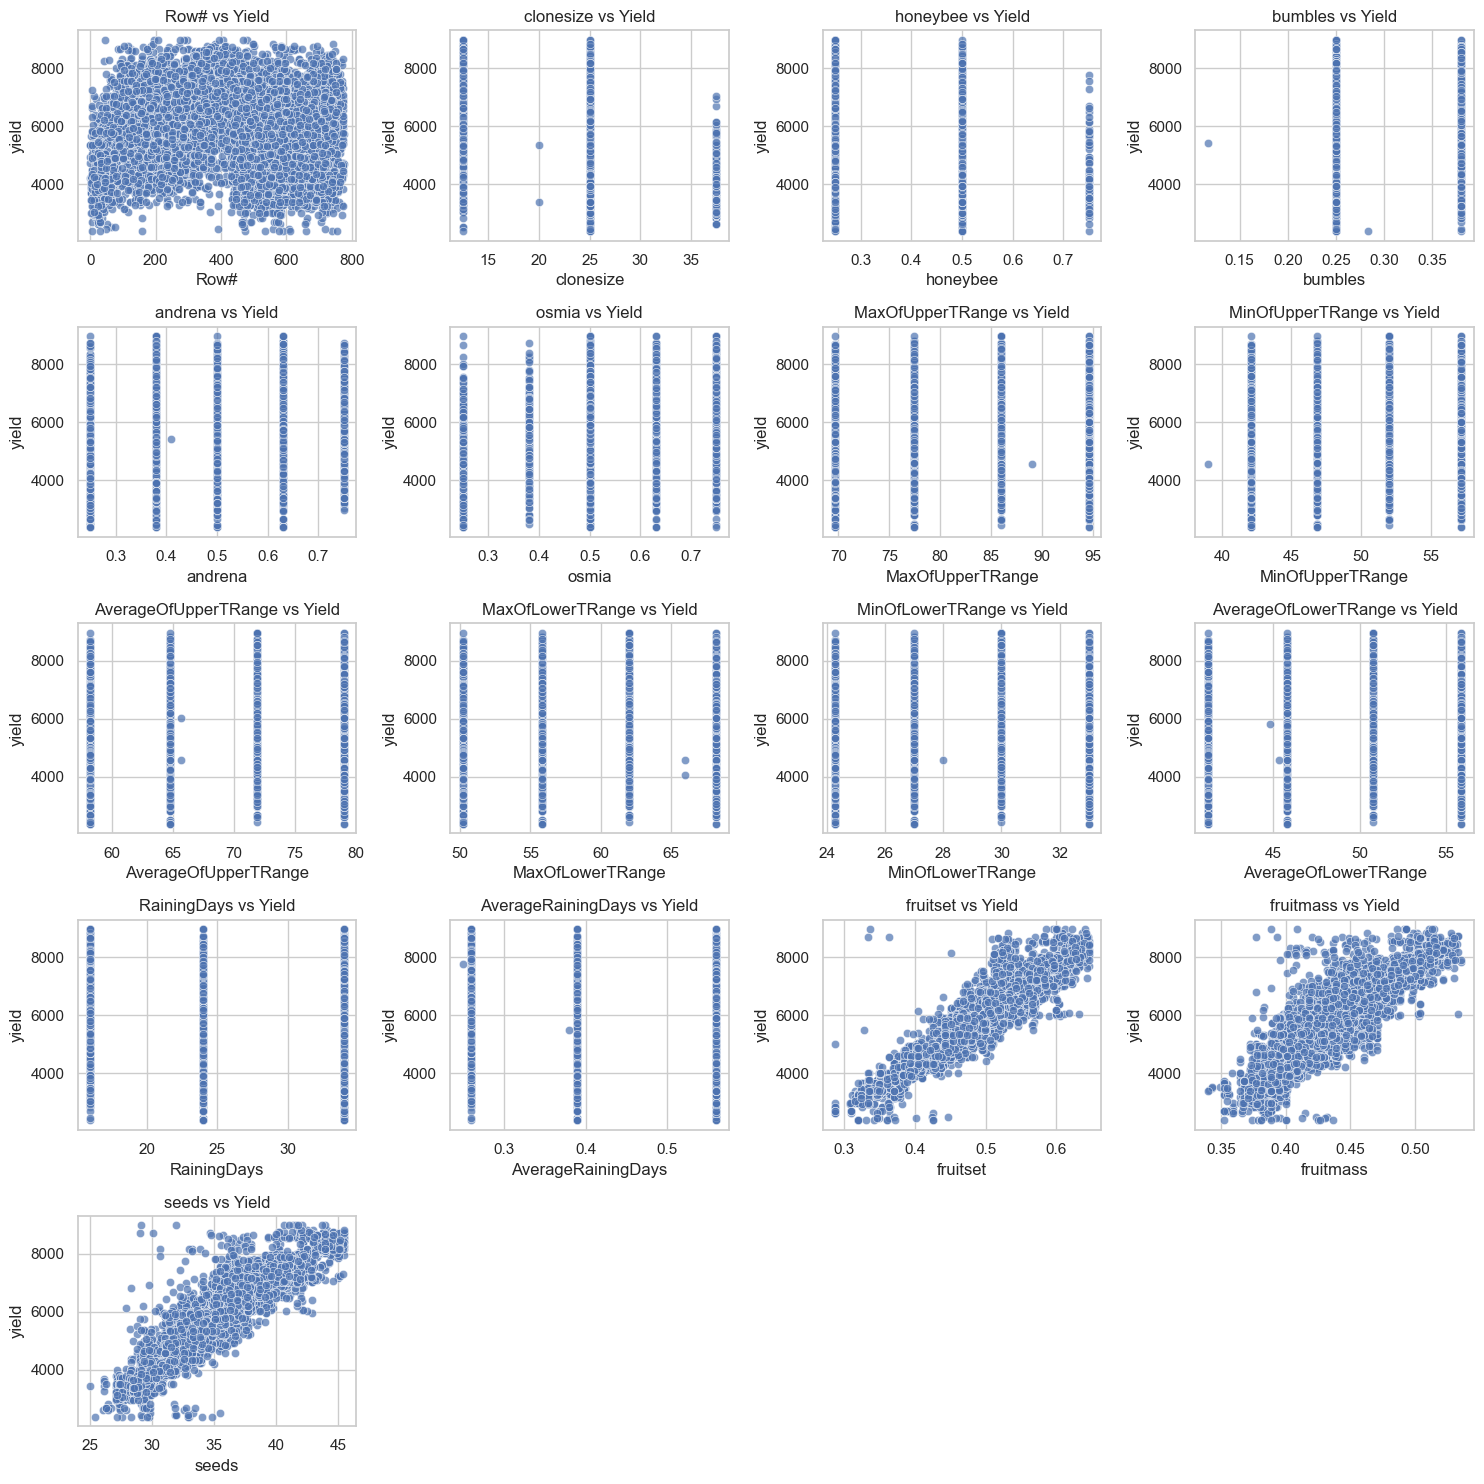

In [301]:
plot_relationship()

In [302]:
import pandas as pd
import numpy as np

def feature_engineering(df):
    # Calculate total fruit mass and total seeds
    df['total_fruitmass'] = df['fruitset'] * df['fruitmass']
    df['total_seeds'] = df['seeds'] * df['fruitmass']

    # Create non-linear features
    non_linear_features = [
        'clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
        'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
        'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
        'RainingDays', 'AverageRainingDays'
    ]
    
    for feature in non_linear_features:
        df[f'{feature}_squared'] = df[feature] ** 2
        df[f'{feature}_cubed'] = df[feature] ** 3

    # Create binned features
    binning_features = ['fruitset', 'fruitmass', 'seeds']
    for feature in binning_features:
        df[f'{feature}_binned'] = pd.cut(df[feature], bins=5, labels=False, include_lowest=True)

    # Calculate temperature range
    df['TemperatureRange'] = df['MaxOfUpperTRange'] - df['MinOfUpperTRange']

    # Calculate total bee activity
    df['TotalBeeActivity'] = df['honeybee'] + df['bumbles'] + df['andrena'] + df['osmia']

    # Create ratio features with division by zero handling
    ratio_features_min = ['MinOfUpperTRange', 'MinOfLowerTRange']
    ratio_features_max = ['MaxOfUpperTRange', 'MaxOfLowerTRange']
    
    for min_feature, max_feature in zip(ratio_features_min, ratio_features_max):
        ratio_column = f'Ratio_{min_feature}_{max_feature}'
        # Avoid division by zero
        df[ratio_column] = df[max_feature] / df[min_feature].replace(0, np.nan)

    return df

In [303]:
train = feature_engineering(train)

In [304]:
train.columns

Index(['Row#', 'clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
       'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds',
       'yield', 'total_fruitmass', 'total_seeds', 'clonesize_squared',
       'clonesize_cubed', 'honeybee_squared', 'honeybee_cubed',
       'bumbles_squared', 'bumbles_cubed', 'andrena_squared', 'andrena_cubed',
       'osmia_squared', 'osmia_cubed', 'MaxOfUpperTRange_squared',
       'MaxOfUpperTRange_cubed', 'MinOfUpperTRange_squared',
       'MinOfUpperTRange_cubed', 'AverageOfUpperTRange_squared',
       'AverageOfUpperTRange_cubed', 'MaxOfLowerTRange_squared',
       'MaxOfLowerTRange_cubed', 'MinOfLowerTRange_squared',
       'MinOfLowerTRange_cubed', 'AverageOfLowerTRange_squared',
       'AverageOfLowerTRange_cubed', 'RainingDays_squared',
       'RainingDays_cubed', 'AverageRainingDays_squ

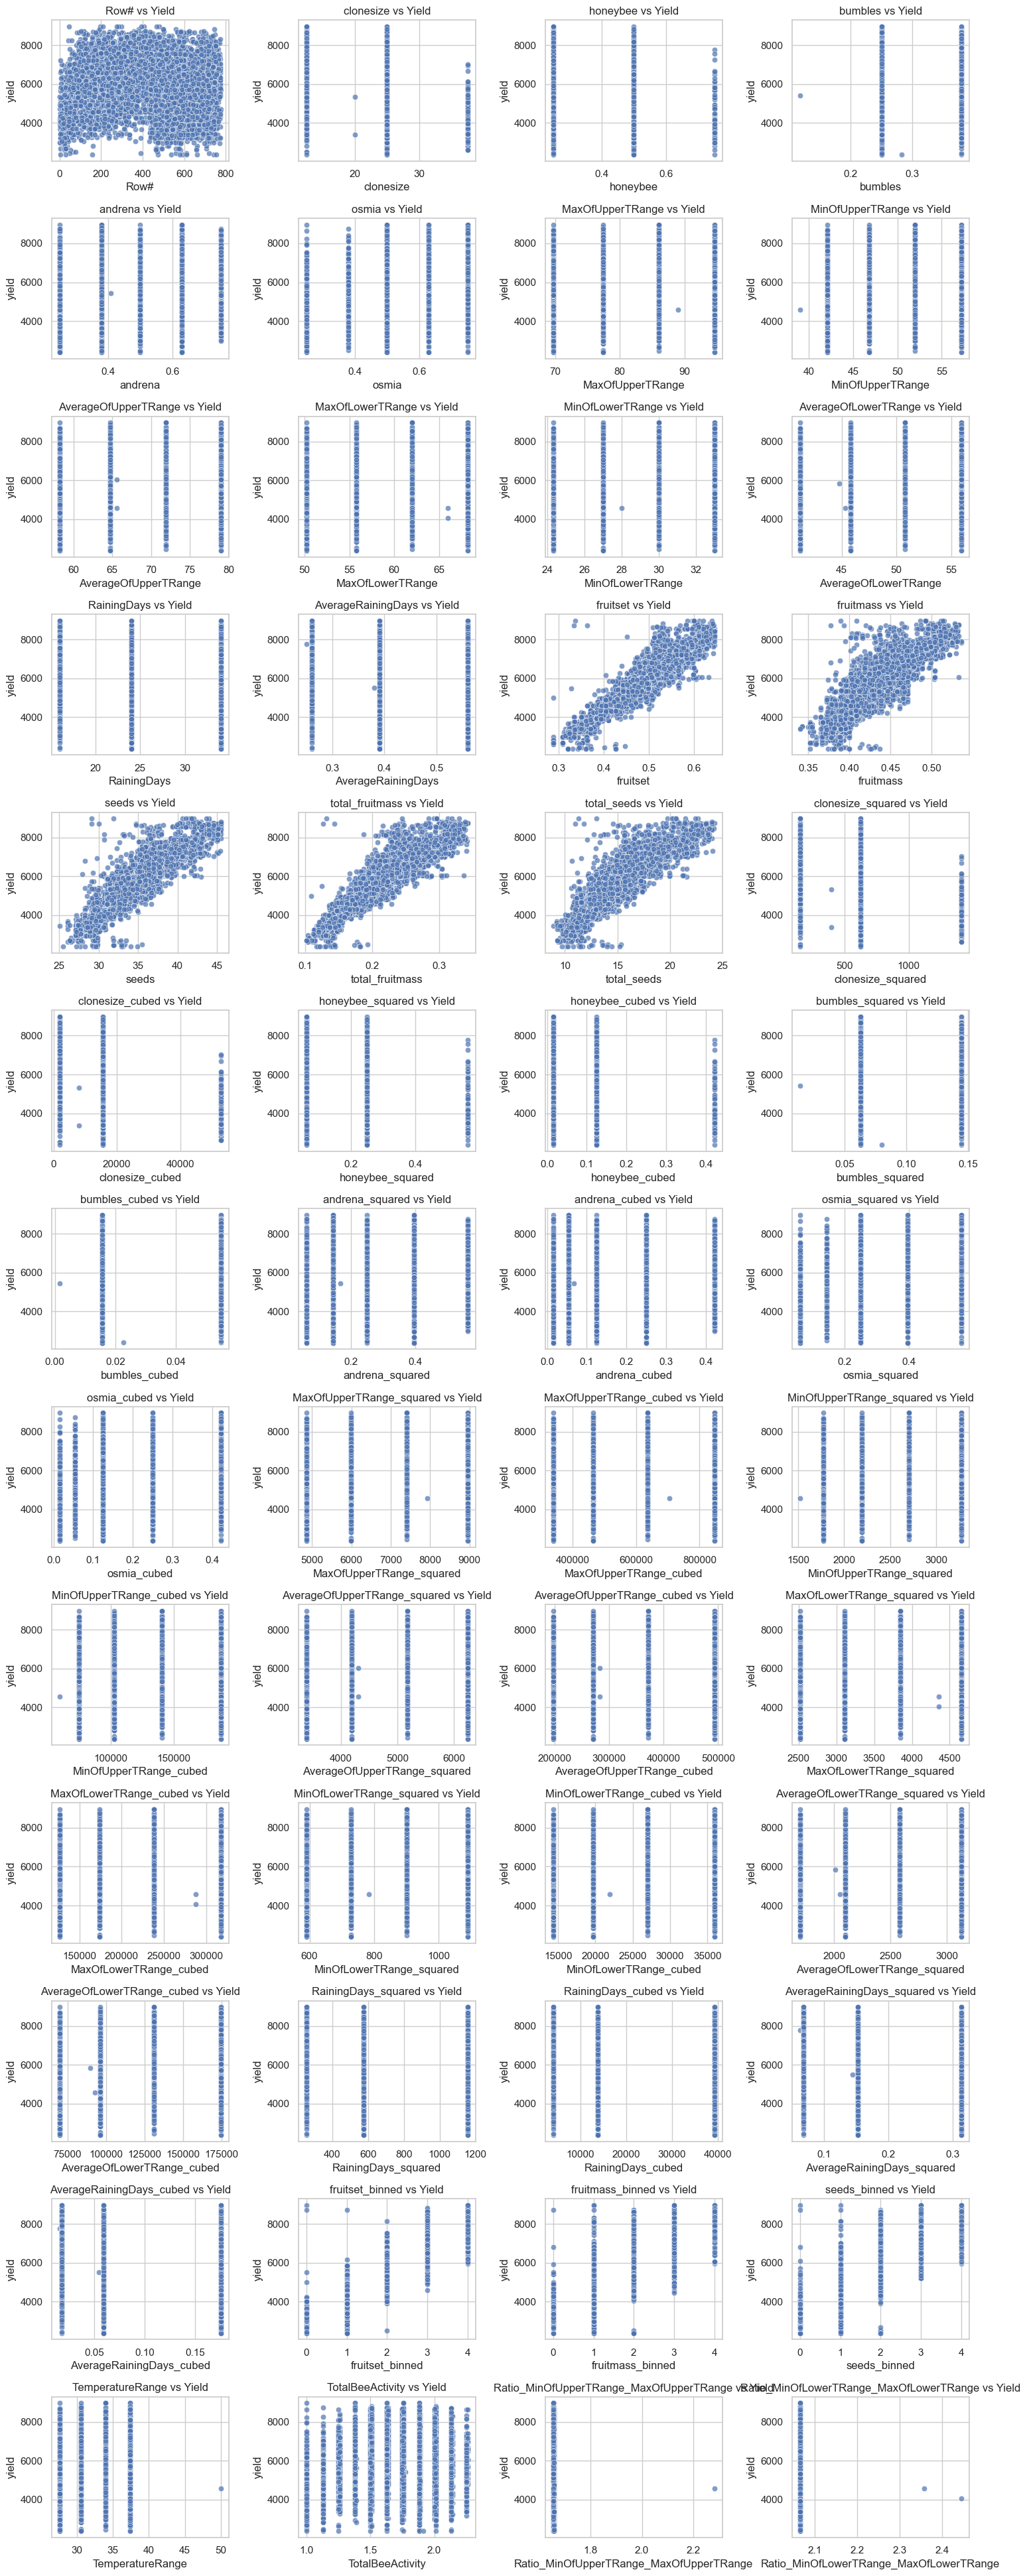

In [305]:
plot_relationship()

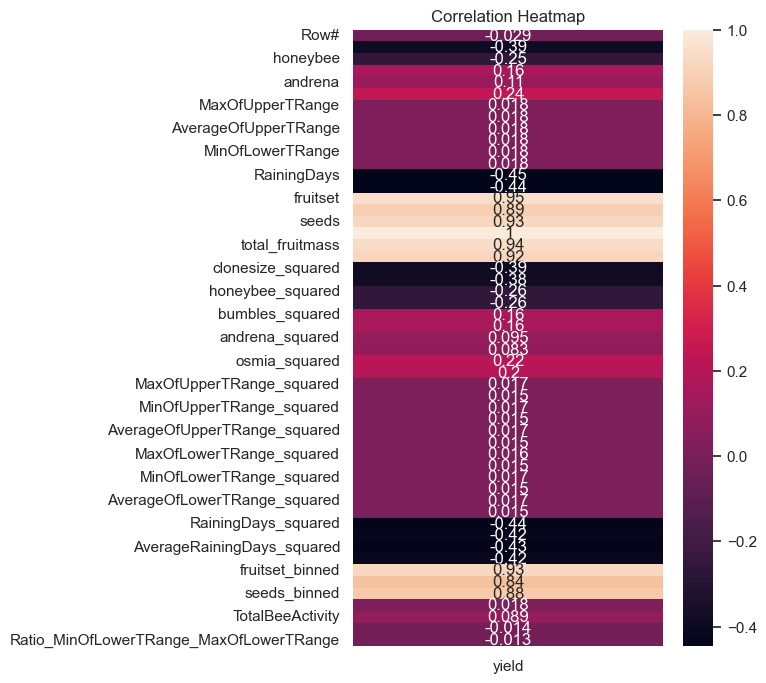

In [306]:
correlation = train.corr()
plt.figure(figsize=(5, 8))
sns.heatmap(correlation[['yield']], annot=True)
plt.title('Correlation Heatmap')
plt.show()

In [307]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

target = 'yield'
X_features = train.drop(target, axis=1)

feature_cols = []
cols = X_features.columns.to_list()
for col in cols:
  if 'Row#' not in col:
    feature_cols.append(col)

X_features = train[feature_cols]

y_features = train[target]

# Initialize model
model = RandomForestRegressor(random_state=101)

# RFE
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X_features, y_features)

# Selected features
selected_features_rfe = X_features.columns[rfe.support_]
print("Selected Features (RFE):", selected_features_rfe)

Selected Features (RFE): Index(['andrena', 'AverageOfLowerTRange', 'fruitset', 'fruitmass', 'seeds',
       'total_fruitmass', 'total_seeds', 'osmia_cubed',
       'MaxOfUpperTRange_squared', 'TotalBeeActivity'],
      dtype='object')


In [309]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer

df = train.copy()

important_features = ['fruitset', 'fruitmass', 'seeds',
                        'total_fruitmass', 'total_seeds']

categorical_features = ['andrena', 'AverageOfLowerTRange',  'osmia_cubed',
                        'MaxOfUpperTRange_squared', 'TotalBeeActivity']

X = df[important_features + categorical_features]
y = df['yield']

X = pd.get_dummies(X, columns=categorical_features)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_poly = X_train.copy()
X_test_poly = X_test.copy()

# Define models and pipelines
models = {
    'GBR': Pipeline([('scaler', StandardScaler()),
                     ('model', GradientBoostingRegressor(random_state=42))]),
    'XGB': Pipeline([('scaler', StandardScaler()),
                     ('model', XGBRegressor(random_state=42))]),
    'RF': Pipeline([('scaler', StandardScaler()),
                    ('model', RandomForestRegressor(random_state=42))])
}

# Hyperparameter grids
param_grids = {
    'GBR': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 4, 5],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2],
        'model__subsample': [0.8, 1.0]
    },
    'XGB': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 4, 5],
        'model__min_child_weight': [1, 3],
        'model__subsample': [0.8, 1.0],
        'model__colsample_bytree': [0.8, 1.0]
    },
    'RF': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1],
        'model__max_features': ['sqrt']
    }
}

best_models = {}

for name, pipeline in models.items():
    print(f"Tuning {name}...")

    random_search = GridSearchCV(pipeline, param_grid=param_grids[name],
                               cv=5, scoring='neg_mean_squared_error',
                               verbose=1, n_jobs=-1)
    random_search.fit(X_train_poly, y_train)
    best_models[name] = random_search.best_estimator_

    y_pred = best_models[name].predict(X_test_poly)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{name} - MSE: {mse}, R2: {r2}, MAE: {mae}")

# Feature importance for the best model
best_model_name = max(best_models, key=lambda x: best_models[x].score(X_test_poly, y_test))
best_model = best_models[best_model_name].named_steps['model']

Tuning GBR...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
GBR - MSE: 114931.3144600589, R2: 0.9284483763472932, MAE: 236.09549627730664
Tuning XGB...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
XGB - MSE: 110983.22561915069, R2: 0.9309062980044085, MAE: 232.5591661397495
Tuning RF...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
RF - MSE: 123563.47722192331, R2: 0.9230743382607411, MAE: 246.79540596586608


In [310]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

ensemble_pred = np.mean([model.predict(X_test_poly) for model in best_models.values()], axis=0)

ensemble_mse = mean_squared_error(y_test, ensemble_pred)
ensemble_r2 = r2_score(y_test, ensemble_pred)
ensemble_mae = mean_absolute_error(y_test, ensemble_pred)
print(f"Ensemble - MSE: {ensemble_mse}, R2: {ensemble_r2}, MAE: {ensemble_mae}")

Ensemble - MSE: 113113.98651863185, R2: 0.9295797717857723, MAE: 235.13669170062016


In [311]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

best_model = best_models[best_model_name]

y_pred_best = best_model.predict(X_test_poly)

best_model_mse = mean_squared_error(y_test, y_pred_best)
best_model_r2 = r2_score(y_test, y_pred_best)
best_model_mae = mean_absolute_error(y_test, y_pred_best)

print(f"Best Model ({best_model_name}) - MSE: {best_model_mse}, R2: {best_model_r2}, MAE: {best_model_mae}")

Best Model (XGB) - MSE: 110983.22561915069, R2: 0.9309062980044085, MAE: 232.5591661397495


In [312]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

val = tmp[len(train) - 100:]
target = 'yield'
y_val = val[target]
val = feature_engineering(val)
val = val[important_features + categorical_features]
val = pd.get_dummies(val, columns=categorical_features)

missing_cols = set(X_train.columns) - set(val.columns)
for col in missing_cols:
    val[col] = 0

val = val[X_train.columns]

ensemble_val_pred = np.mean([model.predict(val) for model in best_models.values()], axis=0)

mae = mean_absolute_error(y_val, ensemble_val_pred)
mse = mean_squared_error(y_val, ensemble_val_pred)
r2 = r2_score(y_val, ensemble_val_pred)

print(f"Ensemble Validation - MSE: {mse}, R2: {r2}, MAE: {mae}")

y_val_pred_best = best_model.predict(val)

best_model_mse = mean_squared_error(y_val, y_val_pred_best)
best_model_r2 = r2_score(y_val, y_val_pred_best)
best_model_mae = mean_absolute_error(y_val, y_val_pred_best)

print(f"Best Model Validation ({best_model_name}) - MSE: {best_model_mse}, R2: {best_model_r2}, MAE: {best_model_mae}")

Ensemble Validation - MSE: 113168.4918696734, R2: 0.9379229950658252, MAE: 222.93500134432884
Best Model Validation (XGB) - MSE: 126325.0607043653, R2: 0.9307061419031222, MAE: 240.59268132342007


/var/folders/7t/_7grmryd2k5d14n8l47fsgb40000gp/T/ipykernel_7476/3268288888.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_fruitmass'] = df['fruitset'] * df['fruitmass']
/var/folders/7t/_7grmryd2k5d14n8l47fsgb40000gp/T/ipykernel_7476/3268288888.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_seeds'] = df['seeds'] * df['fruitmass']
/var/folders/7t/_7grmryd2k5d14n8l47fsgb40000gp/T/ipykernel_7476/3268288888.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [313]:
test = feature_engineering(test)

In [314]:
test.head()

,id,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,...,RainingDays_cubed,AverageRainingDays_squared,AverageRainingDays_cubed,fruitset_binned,fruitmass_binned,seeds_binned,TemperatureRange,TotalBeeActivity,Ratio_MinOfUpperTRange_MaxOfUpperTRange,Ratio_MinOfLowerTRange_MaxOfLowerTRange
0,15000,621.0,25.0,0.50,0.25,0.75,0.75,69.7,42.1,58.2,...,39304.0,0.3136,0.175616,1,1,3,27.6,2.25,1.655582,2.065844
1,15001,246.0,12.5,0.25,0.25,0.50,0.75,94.6,57.2,79.0,...,4096.0,0.0676,0.017576,2,2,4,37.4,1.75,1.653846,2.066667
2,15002,471.0,25.0,0.50,0.25,0.38,0.75,86.0,52.0,71.9,...,13824.0,0.1521,0.059319,2,2,3,34.0,1.88,1.653846,2.066667
3,15003,17.0,37.5,0.25,0.25,0.25,0.25,69.7,42.1,58.2,...,13824.0,0.1521,0.059319,1,1,2,27.6,1.00,1.655582,2.065844
4,15004,585.0,25.0,0.50,0.25,0.63,0.75,86.0,52.0,71.9,...,39304.0,0.3136,0.175616,2,2,3,34.0,2.13,1.653846,2.066667


In [315]:
X_real = test[important_features + categorical_features]
X_real = pd.get_dummies(X_real, columns=categorical_features)

missing_cols = set(X_train.columns) - set(X_real.columns)
for col in missing_cols:
    X_real[col] = 0
X_real = X_real[X_train.columns]

print("Predicting on real data...")
ensemble_real_pred = np.mean([model.predict(X_real) for model in best_models.values()], axis=0)
print(f"Ensemble predictions on real data: {ensemble_real_pred}")

Predicting on real data...
Ensemble predictions on real data: [5240.66537028 6748.82808006 5474.94835592 ... 6329.53931431 6036.01253384
 5397.2809196 ]


In [316]:
len(test)

10000

In [317]:
len(ensemble_real_pred)

10000

In [318]:
sub = pd.DataFrame({'id': test['id'], 'yield': ensemble_real_pred})

In [319]:
sub.head()

,id,yield
0,15000,5240.665370
1,15001,6748.828080
2,15002,5474.948356
3,15003,3501.591383
4,15004,5641.947753


In [320]:
sub.to_csv('submission.csv', index=False)